In [1]:
%load_ext Cython
import numpy as np
ň = np.newaxis
from scipy.constants import epsilon_0 as ε_0, c, pi as π, e, hbar as ℏ
eV = e
from scipy.special import lpmn, lpmv, sph_jn, sph_yn, poch
from scipy.misc import factorial
import math
import cmath

In [2]:
%%cython
# cythonized functions here
cimport numpy as np
import numpy as np
cimport cython

## Auxillary function for retrieving the "meshgrid-like" indices; inc. nmax
@cython.boundscheck(False)
def get_mn_y(int nmax):
    """
    Auxillary function for retreiving the 'meshgrid-like' indices from the flat indexing; 
    inc. nmax.
    ('y to mn' conversion)
    
    Parameters
    ----------

    nmax : int
        The maximum order to which the VSWFs / Legendre functions etc. will be evaluated.
        
    Returns
    -------
    
    output : (m, n)
        Tuple of two arrays of type np.array(shape=(nmax*nmax + 2*nmax), dtype=np.int),
        where [(m[y],n[y]) for y in range(nmax*nmax + 2*nma)] covers all possible 
        integer pairs n >= 1, -n <= m <= n.
    """
    cdef Py_ssize_t nelems = nmax * nmax + 2 * nmax
    cdef np.ndarray[np.int_t,ndim=1] m_arr = np.empty([nelems], dtype=np.int)
    cdef np.ndarray[np.int_t,ndim=1] n_arr = np.empty([nelems], dtype=np.int)
    cdef Py_ssize_t i = 0
    cdef np.int_t n, m
    for n in range(1,nmax+1):
        for m in range(-n,n+1):
            m_arr[i] = m
            n_arr[i] = n
            i = i + 1
    return (m_arr, n_arr)

def get_y_mn_unsigned(int nmax): 
    """
    Auxillary function for mapping 'unsigned m', n indices to the flat y-indexing.
    For use with functions as scipy.special.lpmn, which have to be evaluated separately
    for positive and negative m.
    
    Parameters
    ----------

    nmax : int
        The maximum order to which the VSWFs / Legendre functions etc. will be evaluated.
        
    output : (ymn_plus, ymn_minus)
        Tuple of two arrays of shape (nmax+1,nmax+1), containing the flat y-indices corresponding
        to the respective (m,n) and (-m,n). The elements for which |m| > n are set to -1.
        (Therefore, the caller must not use those elements equal to -1.)
    """
    cdef np.ndarray[np.intp_t, ndim=2] ymn_plus = np.full((nmax+1,nmax+1),-1, dtype=np.intp)
    cdef np.ndarray[np.intp_t, ndim=2] ymn_minus = np.full((nmax+1,nmax+1),-1, dtype=np.intp)
    cdef Py_ssize_t i = 0
    cdef np.int_t n, m
    for n in range(1,nmax+1):
        for m in range(-n,0):
            ymn_minus[-m,n] = i
            i = i + 1
        for m in range(0,n+1):
            ymn_plus[m,n] = i
            i = i + 1
    return(ymn_plus, ymn_minus)

In [3]:
# Coordinate transforms for arrays of "arbitrary" shape
def cart2sph(cart,axis=-1):
    if (cart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [x, y, z] = np.split(cart,3,axis=axis)
    r = np.linalg.norm(cart,axis=axis,keepdims=True)
    r_zero = np.logical_not(r)
    θ = np.arccos(z/(r+r_zero))
    φ = np.arctan2(y,x) # arctan2 handles zeroes correctly itself
    return np.concatenate((r,θ,φ),axis=axis)

def sph2cart(sph, axis=-1):
    if (sph.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    x = r * sinθ * np.cos(φ)
    y = r * sinθ * np.sin(φ)
    z = r * np.cos(θ)
    return np.concatenate((x,y,z),axis=axis)

def sph_loccart2cart(loccart, sph, axis=-1):
    """
    Transformation of vector specified in local orthogonal coordinates 
    (tangential to spherical coordinates – basis r̂,θ̂,φ̂) to global cartesian
    coordinates (basis x̂,ŷ,ẑ)
    SLOW FOR SMALL ARRAYS
    
    Parameters
    ----------
    loccart: ... TODO
        the transformed vector in the local orthogonal coordinates
        
    sph: ... TODO
        the point (in spherical coordinates) at which the locally
        orthogonal basis is evaluated
    
    output: ... TODO
        The coordinates of the vector in global cartesian coordinates
    """
    if (loccart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    cosθ = np.cos(θ)
    sinφ = np.sin(φ)
    cosφ = np.cos(φ)
    
    #x = r * sinθ * cosφ
    #y = r * sinθ * sinφ
    #z = r * cosθ
    r̂x = sinθ * cosφ
    r̂y = sinθ * sinφ
    r̂z = cosθ
    θ̂x = cosθ * cosφ
    θ̂y = cosθ * sinφ
    θ̂z = -sinθ
    φ̂x = -sinφ
    φ̂y = cosφ
    φ̂z = np.zeros(φ̂y.shape)
    r̂ = np.concatenate((r̂x,r̂y,r̂z),axis=axis)
    θ̂ = np.concatenate((θ̂x,θ̂y,θ̂z),axis=axis)
    φ̂ = np.concatenate((φ̂x,φ̂y,φ̂z),axis=axis)
    [inr̂,inθ̂,inφ̂] = np.split(loccart,3,axis=axis)
    out=inr̂*r̂+inθ̂*θ̂+inφ̂*φ̂
    return out


def lpy(nmax, z):
    """
    Associated legendre function and its derivatative at z in the 'y-indexing'.
    (Without Condon-Shortley phase AFAIK.)
    NOT THOROUGHLY TESTED
    
    Parameters
    ----------
    
    nmax: int
        The maximum order to which the Legendre functions will be evaluated..
        
    z: float
        The point at which the Legendre functions are evaluated.
        
    output: (P_y, dP_y) TODO
        y-indexed legendre polynomials and their derivatives
    
    """
    pmn_plus, dpmn_plus = lpmn(nmax, nmax, z)
    pmn_minus, dpmn_minus = lpmn(-nmax, nmax, z)
    nelem = nmax * nmax + 2*nmax
    P_y = np.empty((nelem), dtype=np.float_)
    dP_y = np.empty((nelem), dtype=np.float_)
    mn_p_y, mn_n_y = get_y_mn_unsigned(nmax)
    mn_plus_mask = (mn_p_y >= 0)
    mn_minus_mask = (mn_n_y >= 0)
    #print( mn_n_y[mn_minus_mask])
    P_y[mn_p_y[mn_plus_mask]] = pmn_plus[mn_plus_mask]
    P_y[mn_n_y[mn_minus_mask]] = pmn_minus[mn_minus_mask]
    dP_y[mn_p_y[mn_plus_mask]] = dpmn_plus[mn_plus_mask]
    dP_y[mn_n_y[mn_minus_mask]] = dpmn_minus[mn_minus_mask]
    return (P_y, dP_y)

def vswf_yr(pos_sph,nmax,J=1):
    """
    Normalized vector spherical wavefunctions $\widetilde{M}_{mn}^{j}$,
    $\widetilde{N}_{mn}^{j}$ as in [1, (2.40)].
    
    Parameters
    ----------
    
    pos_sph : np.array(dtype=float, shape=(someshape,3))
        The positions where the spherical vector waves are to be
        evaluated. The last axis corresponds to the individual
        points (r,θ,φ). The radial coordinate r is dimensionless,
        assuming that it has already been multiplied by the
        wavenumber.
    
    nmax : int
        The maximum order to which the VSWFs are evaluated.
        
    Returns
    -------
    
    output : np.array(dtype=complex, shape=(someshape,nmax*nmax + 2*nmax,3))
        Spherical vector wave functions evaluated at pos_sph,
        in the local basis (r̂,θ̂,φ̂). The last indices correspond
        to m, n (in the ordering given by mnindex()), and basis 
        vector index, respectively.
        
    [1] Jonathan M. Taylor. Optical Binding Phenomena: Observations and
    Mechanisms.
    """
    #mi, ni = mnindex(nmax)
    #nelems = nmax*nmax + 2*nmax
    ## TODO Remove these two lines in production:
    #if(len(mi) != nelems):
    #    raise ValueError("This is very wrong.")
    ## Pre-calculate the associated Legendre function
    #Prmn, dPrmn = lpmn(nmax,nmax,)
    ## Normalized funs π̃, τ̃
    #π̃ = 
    pass

from scipy.special import sph_jn, sph_yn
def _sph_zn_1(n,z):
    return sph_jn(n,z)
def _sph_zn_2(n,z):
    return sph_yn(n,z)
def _sph_zn_3(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] + 1j*besy[0],besj[1] + 1j*besy[1])
def _sph_zn_4(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] - 1j*besy[0],besj[1] - 1j*besy[1])
_sph_zn = [_sph_zn_1,_sph_zn_2,_sph_zn_3,_sph_zn_4]

# computes bessel/hankel functions for orders from 0 up to n; drops
# the derivatives which are also included in scipy.special.sph_jn/yn
def zJn(n, z, J=1):
    return _sph_zn[J-1](n=n,z=z)

def get_π̃τ̃_y1(θ,nmax):
    # TODO replace with the limit functions (below) when θ approaches
    # the extreme values at about 1e-6 distance
    """
    (... TODO)
    
    """
    
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    Py, dPy = lpy(nmax, math.cos(θ))
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm * my * Py / math.sin(θ)  # bacha, možné dělení nulou
    τ̃_y = prenorm * dPy * (- math.sin(θ))  # TADY BACHA!!!!!!!!!! * (- math.sin(pos_sph[1])) ???
    return (π̃_y,τ̃_y)

# The following 4 funs have to be refactored, possibly merged
def π̃_zerolim(nmax): # seems OK
    """
    lim_{θ→ 0-} π̃(cos θ)
    """
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    π̃_y = np.zeros((nelems))
    plus1mmask = (my == 1)
    minus1mmask = (my == -1)
    pluslim = -ny*(1+ny)/2
    minuslim = 0.5
    π̃_y[plus1mmask] = pluslim[plus1mmask]
    π̃_y[minus1mmask] = - minuslim
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm *     π̃_y
    return π̃_y

def π̃_pilim(nmax): # Taky OK, jen to možná není kompatibilní se vzorečky z mathematiky
    """
    lim_{θ→ π+} π̃(cos θ)
    """
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    π̃_y = np.zeros((nelems))
    plus1mmask = (my == 1)
    minus1mmask = (my == -1)
    pluslim = (-1)**ny*ny*(1+ny)/2
    minuslim = 0.5*(-1)**ny
    π̃_y[plus1mmask] = pluslim[plus1mmask]
    π̃_y[minus1mmask] = minuslim[minus1mmask]
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm *     π̃_y
    return π̃_y

def τ̃_zerolim(nmax):
    """
    lim_{θ→ 0-} τ̃(cos θ)
    """
    p0 = π̃_zerolim(nmax)
    my, ny = get_mn_y(nmax)
    minus1mmask = (my == -1)
    p0[minus1mmask] = -p0[minus1mmask]
    return p0

def τ̃_pilim(nmax):
    """
    lim_{θ→  π+} τ̃(cos θ)
    """
    t = π̃_pilim(nmax)
    my, ny = get_mn_y(nmax)
    plus1mmask = (my == 1)
    t[plus1mmask] = -t[plus1mmask]
    return t
    
    
def vswf_yr1(pos_sph,nmax,J=1):
    """
    As vswf_yr, but evaluated only at single position (i.e. pos_sph has
    to have shape=(3))
    """
    my, ny = get_mn_y(nmax)
    Py, dPy = lpy(nmax, math.cos(pos_sph[1]))
    nelems = nmax*nmax + 2*nmax
    # TODO Remove these two lines in production:
    if(len(Py) != nelems or len(my) != nelems):
        raise ValueError("This is very wrong.")
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm * my * Py / math.sin(pos_sph[1])  # bacha, možné dělení nulou
    τ̃_y = prenorm * dPy * (- math.sin(pos_sph[1]))  # TADY BACHA!!!!!!!!!! * (- math.sin(pos_sph[1])) ???
    z_n, dz_n = zJn(nmax, pos_sph[0], J=J)
    z_y = z_n[ny]
    dz_y = dz_n[ny]
    eimf_y = np.exp(1j*my*pos_sph[2]) # zbytečné opakování my, lepší by bylo to spočítat jednou a vyindexovat
    M̃_y = np.zeros((nelems,3), dtype=np.complex_)
    M̃_y[:,1] = 1j * π̃_y * eimf_y * z_y
    M̃_y[:,2]    -   τ̃_y * eimf_y * z_y
    Ñ_y = np.empty((nelems,3), dtype=np.complex_)
    Ñ_y[:,0] = (ny*(ny+1)/pos_sph[0]) * prenorm * Py * eimf_y * z_y
    Ñradial_fac_y = z_y / pos_sph[0] + dz_y
    Ñ_y[:,1] =    τ̃_y * eimf_y * Ñradial_fac_y
    Ñ_y[:,2] = 1j*π̃_y * eimf_y * Ñradial_fac_y
    return(M̃_y, Ñ_y)
    
#def plane_E_y(nmax):
#    """
#    The E_mn normalization factor as in [1, (3)] WITHOUT the E_0 factor,
#    y-indexed
#    
#    (... TODO)
#    
#    References
#    ----------
#    [1] Jonathan M. Taylor. Optical Binding Phenomena: Observations and
#    Mechanisms. FUCK, I MADE A MISTAKE: THIS IS FROM 7U
#    """
#    my, ny = get_mn_y(nmax)
#    return 1j**ny * np.sqrt((2*ny+1)*factorial(ny-my) /
#                            (ny*(ny+1)*factorial(ny+my))
#    )

def zplane_pq_y(nmax, betap = 0):
    """
    The z-propagating plane wave expansion coefficients as in [1, (1.12)]
    
    (... TODO)
    """
    my, ny = get_mn_y(nmax)
    U_y = 4*π * 1j**ny / (ny * (ny+1))
    π̃_y = π̃_zerolim(nmax)
    τ̃_y = τ̃_zerolim(nmax)
    
    # fixme co je zač ten e_θ ve vzorečku? (zde neimplementováno)
    p_y = U_y*(τ̃_y*math.cos(betap) - 1j*math.sin(betap)*π̃_y)
    q_y = U_y*(π̃_y*math.cos(betap) - 1j*math.sin(betap)*τ̃_y)
    return (p_y, q_y)
    

In [22]:
# Functions copied from scattering_xu, additionaly normalized
from py_gmm.gmm import vec_trans as vc

def q_max(m,n,μ,ν):
    return min(n,ν,(n+ν-abs(m+μ))/2)
    
# returns array with indices corresponding to q
# argument q does nothing for now
def a_q(m,n,μ,ν,q = None):
    qm=q_max(m,n,μ,ν)
    res, err= vc.gaunt_xu(m,n,μ,ν,qm)
    if(err):
        print("m,n,μ,ν,qm = ",m,n,μ,ν,qm)
        raise ValueError('Something bad in the fortran subroutine gaunt_xu happened')
    return res

# All arguments are single numbers (for now)
# ZDE VYCHÁZEJÍ DIVNÁ ZNAMÉNKA
def Ã(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(math.lgamma(2*n+1)-math.lgamma(n+2)+math.lgamma(2*ν+3)-math.lgamma(ν+2) 
                +math.lgamma(n+ν+m-μ+1)-math.lgamma(n-m+1)-math.lgamma(ν+μ+1)
                +math.lgamma(n+ν+1) - math.lgamma(2*(n+ν)+1))
    presum = math.exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**μ * 1j**(ν+n) / (4*n)
    qmax = math.floor(q_max(-m,n,μ,ν)) #nemá tu být +m?
    q = np.arange(qmax+1, dtype=int)
    # N.B. -m !!!!!!
    a1q = a_q(-m,n,μ,ν) # there is redundant calc. of qmax
    ã1q = a1q / a1q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp = zJn(n+ν,kdlj,J)[0][p]
    Pp = lpmv(μ-m,p,math.cos(θlj))
    summandq = (n*(n+1) + ν*(ν+1) - p*(p+1)) * (-1)**q * ã1q * zp * Pp
  
    # Taylor normalisation v2, proven to be equivalent (NS which is better)
    prenormratio = math.sqrt(((2*ν+1)/(2*n+1))* math.exp(
        math.lgamma(n+m+1)-math.lgamma(n-m+1)+math.lgamma(ν-μ+1)-math.lgamma(ν+μ+1)))
    presum = presum * prenormratio
    
    # Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*π*factorial(n+m)))
    #prenormμν =  math.sqrt((2*ν + 1)*math.factorial(ν-μ)/(4*π*factorial(ν+μ)))
    #presum = presum * prenormμν / prenormmn
    
    return presum * np.sum(summandq)
    
# ZDE OPĚT JINAK ZNAMÉNKA než v Xu (J. comp. phys 127, 285)
def B̃(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(math.lgamma(2*n+3)-math.lgamma(n+2)+math.lgamma(2*ν+3)-math.lgamma(ν+2) 
                +math.lgamma(n+ν+m-μ+2)-math.lgamma(n-m+1)-math.lgamma(ν+μ+1)
                +math.lgamma(n+ν+2) - math.lgamma(2*(n+ν)+3))
    presum = math.exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**μ * 1j**(ν+n+1) / (
        (4*n)*(n+1)*(n+m+1))
    Qmax = math.floor(q_max(-m,n+1,μ,ν))
    q = np.arange(Qmax+1, dtype=int)
    if (μ == ν): # it would disappear in the sum because of the factor (ν-μ) anyway
        ã2q = 0
    else:
        a2q = a_q(-m-1,n+1,μ+1,ν)
        ã2q = a2q / a2q[0]
    a3q = a_q(-m,n+1,μ,ν)
    ã3q = a3q / a3q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp_ = zJn(n+1+ν,kdlj,J)[0][p+1] # je ta +1 správně?
    Pp_ = lpmv(μ-m,p+1,math.cos(θlj))
    summandq = ((2*(n+1)*(ν-μ)*ã2q
                 -(-ν*(ν+1) - n*(n+3) - 2*μ*(n+1)+p*(p+3))* ã3q)
                *(-1)**q * zp_ * Pp_)
    
    # Taylor normalisation v2, proven to be equivalent
    prenormratio = math.sqrt(((2*ν+1)/(2*n+1))* math.exp(
        math.lgamma(n+m+1)-math.lgamma(n-m+1)+math.lgamma(ν-μ+1)-math.lgamma(ν+μ+1)))
    presum = presum * prenormratio
    
    ## Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*π*factorial(n+m)))
    #prenormμν =  math.sqrt((2*ν + 1)*math.factorial(ν-μ)/(4*π*factorial(ν+μ)))
    #presum = presum * prenormμν / prenormmn
    
    return presum * np.sum(summandq)
 

TODOs
====
Implement/improve the zero zenithal angle stuff

Rewrite the functions zJn, lpy in (at least simulated) universal manner.
Then universalise the rest


In [161]:
print(get_π̃τ̃_y1(0.001,nmax))
print(get_π̃τ̃_y1(0.00001,nmax))

(array([ -3.45494149e-01,   0.00000000e+00,  -3.45494149e-01,
        -7.72548275e-04,  -7.72548018e-01,   0.00000000e+00,
        -7.72548018e-01,   7.72548275e-04,  -1.25167105e-06,
        -2.04396959e-03,  -1.29271912e+00,   0.00000000e+00,
        -1.29271912e+00,   2.04396959e-03,  -1.25167105e-06]), array([  3.45493977e-01,  -4.88602430e-04,  -3.45493977e-01,
         7.72547889e-04,   7.72546859e-01,  -1.89234813e-03,
        -7.72546859e-01,   7.72547889e-04,   1.25167043e-06,
         2.04396755e-03,   1.29271524e+00,  -4.47810965e-03,
        -1.29271524e+00,   2.04396755e-03,  -1.25167043e-06]))
(array([ -3.45494164e-01,   0.00000000e+00,  -3.45494164e-01,
        -7.72548468e-06,  -7.72548436e-01,   0.00000000e+00,
        -7.72548436e-01,   7.72548468e-06,  -1.25167163e-10,
        -2.04397112e-05,  -1.29272079e+00,   0.00000000e+00,
        -1.29272079e+00,   2.04397112e-05,  -1.25167163e-10]), array([  3.45494135e-01,  -4.88602512e-06,  -3.45494135e-01,
         7.72548

In [26]:
x = np.array([0.5,math.pi/2,0])
M̃_y, Ñ_y=vswf_yr1(x,3)
Mcart_y = sph_loccart2cart(M̃_y, x, axis=-1)
Ncart_y = sph_loccart2cart(Ñ_y, x, axis=-1)

In [28]:
print(Mcart_y)

[[ 0. -3.43853837e-18j  0. +0.00000000e+00j  0. +5.61555932e-02j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0. -3.43853837e-18j  0. +0.00000000e+00j  0. +5.61555932e-02j]
 [ 0. -7.74434322e-19j  0. +0.00000000e+00j  0. +1.26474723e-02j]
 [ 0. -4.74204257e-35j  0. +0.00000000e+00j  0. +7.74434322e-19j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0. -4.74204257e-35j  0. +0.00000000e+00j  0. +7.74434322e-19j]
 [ 0. +7.74434322e-19j  0. +0.00000000e+00j  0. -1.26474723e-02j]
 [ 0. -8.99813320e-20j  0. +0.00000000e+00j  0. +1.46950667e-03j]
 [ 0. -8.99741267e-36j  0. +0.00000000e+00j  0. +1.46938900e-19j]
 [ 0. +2.32330800e-20j  0. +0.00000000e+00j  0. -3.79424991e-04j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0. +2.32330800e-20j  0. +0.00000000e+00j  0. -3.79424991e-04j]
 [ 0. +8.99741267e-36j  0. +0.00000000e+00j  0. -1.46938900e-19j]
 [ 0. -8.99813320e-20j  0. +0.00000000e+00j  0. +1.46950667e-03j]]


0.80034947115 2.63677968348e-16 2.72931973385e-16


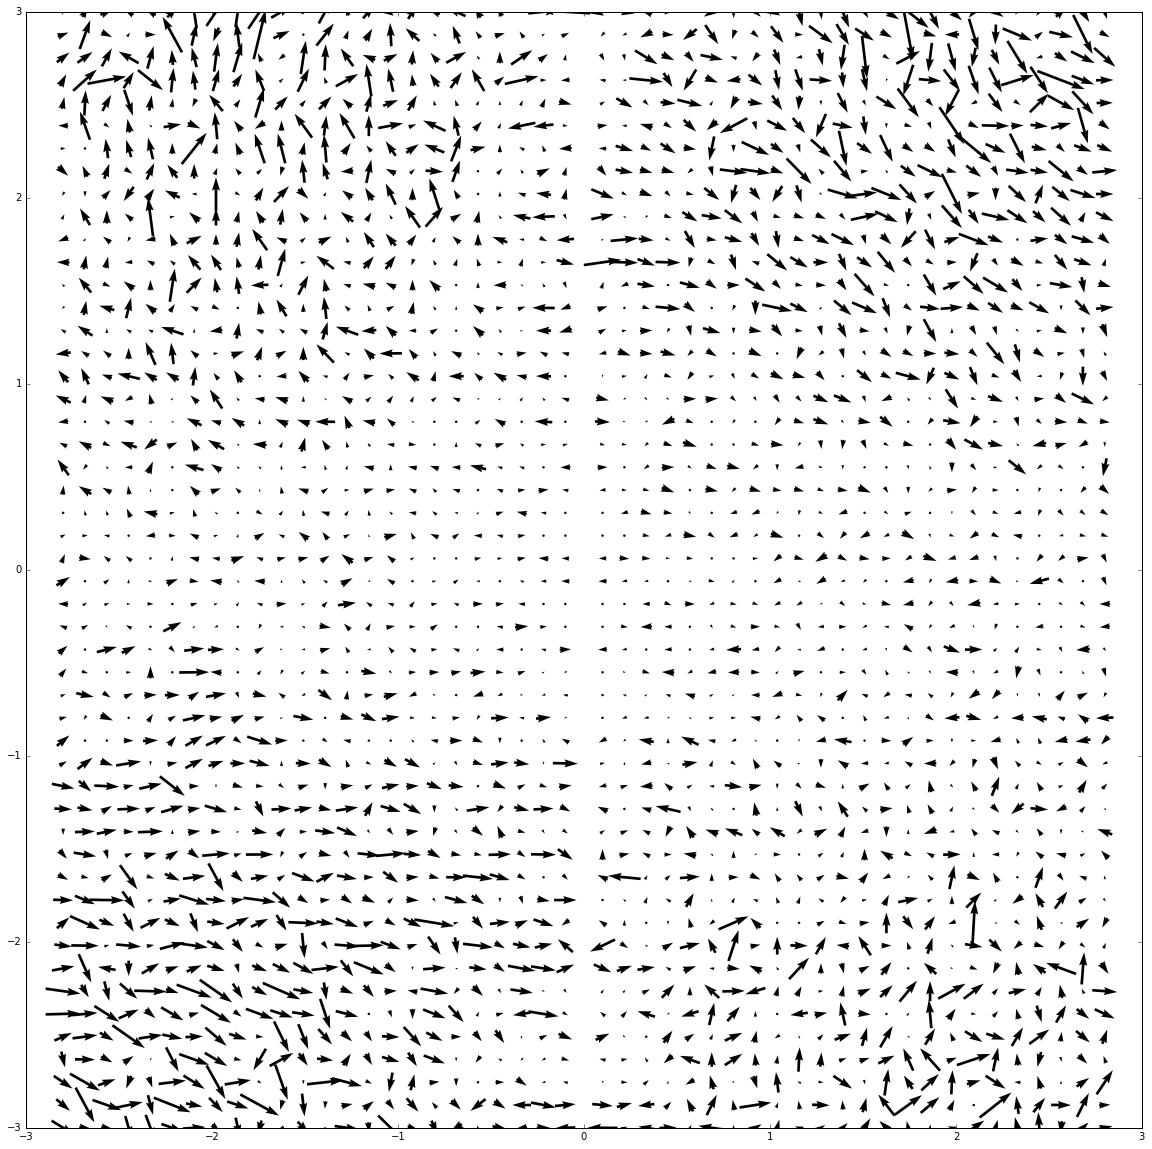

In [277]:
# Test rovinných vln
# AZIMUTÁLNÍ SLOŽKA VYCHÁZÍ DIVNĚ!!!!
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 40
z = np.linspace(-3,3)
x = [0]
y = np.concatenate((np.linspace(-2.8,-0.1,24),np.linspace(0.1,2.8,24)))

nelem = nmax * (nmax + 2)
x,y,z = np.meshgrid(x,y,z)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
betap = 0.1
E⃗_0 = np.array([math.cos(betap),math.sin(betap),0])
E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*z)[:,np.newaxis]
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)

p_y, q_y = zplane_pq_y(nmax,betap)
E_inc = -1j*np.sum( (p_y[ň,:,ň] * N_cart_ry
                    +q_y[ň,:,ň] * M_cart_ry
                    ),
                   axis = -2)

plt.figure(figsize=(20,20))
#plotfield = E_plane[:,:].real
#plotfield = E_inc[:,:].real

#plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
#plotfield = M_cart_ry[:,7,:].imag
plt.quiver(cartgrid[:,1], cartgrid[:,2], plotfield[:,1], plotfield[:,2],pivot='mid')
print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))


In [228]:
x = x.flatten()


In [279]:
%timeit vc.gaunt_xu(7,42,-15,44,q_max(7,42,-15,44))

The slowest run took 9.23 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 5.78 µs per loop


In [294]:
A(10,20,3,22,2.0,0.5,0.5,False,3)

(1.264361079940522e+57+3.3753591819622551e+57j)

In [295]:
Ã(10,20,3,22,2.0,0.5,0.5,False,3)

(1.0029018662999673e+66+2.6773633550804335e+66j)

In [300]:
%timeit Ã(10,20,3,22,2.0,0.5,0.5,False,3)

10000 loops, best of 3: 125 µs per loop


max|Re Vx| = 0.993139891943 ; max|Re Vy| = 0.0995424995706 ; max|Re Vz| = 4.62282757669e-13
max|Im Vx| = 0.994200926692 ; max|Im Vy| = 0.0498264815529 ; max|Im Vz| = 2.28421162908e-14
(0.993139891943+0.0608805712149j) (0.0995424995706+0.00305167110684j) (4.62282323988e-13-1.53822244234e-14j)


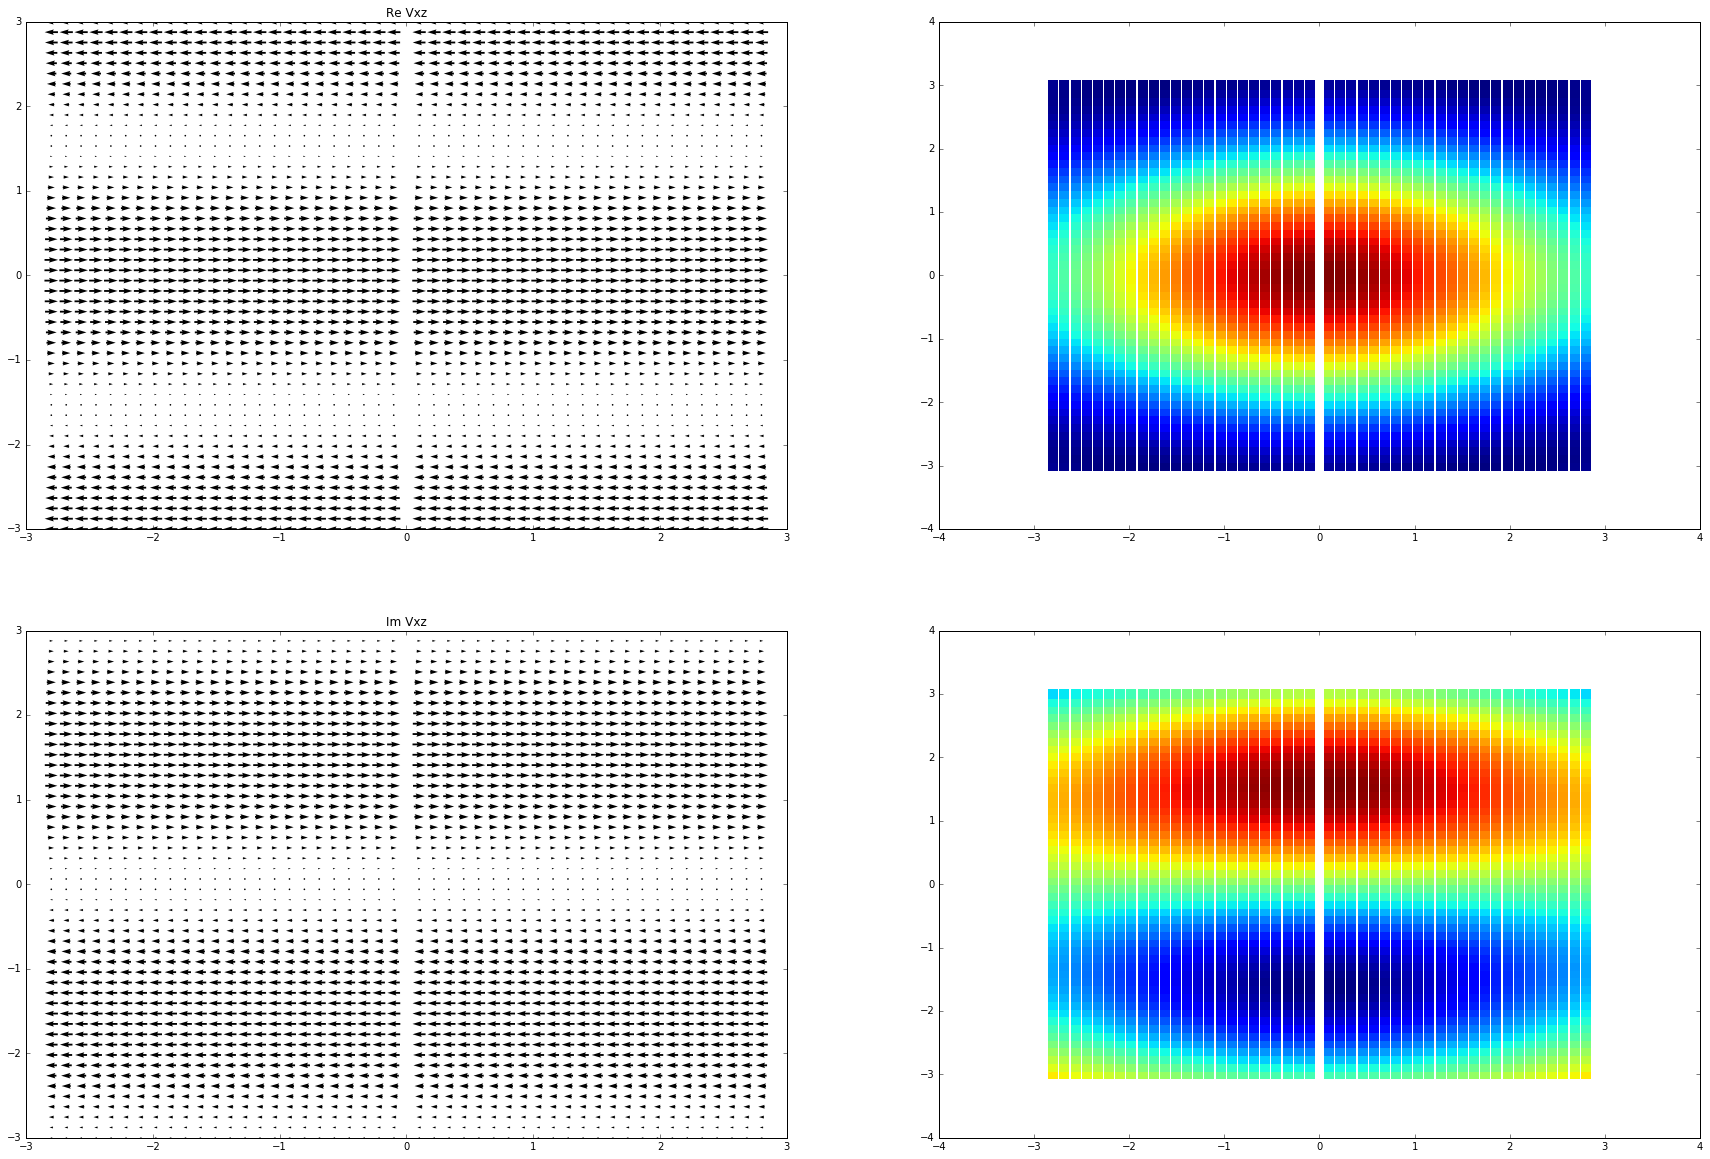

In [306]:
# Test rovinných vln podruhé: zde je vidět možný problém s kolmou (asimutální)
# částí řezu
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 20
z = np.linspace(-3,3)
y = [0]
x = np.concatenate((np.linspace(-2.8,-0.1,24),np.linspace(0.1,2.8,24)))

nelem = nmax * (nmax + 2)
x,y,z = np.meshgrid(x,y,z)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
betap = 0.1
E⃗_0 = np.array([math.cos(betap),math.sin(betap),0])
E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*z)[:,np.newaxis]
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)

p_y, q_y = zplane_pq_y(nmax,betap)
E_inc = -1j*np.sum( (p_y[ň,:,ň] * N_cart_ry
                    +q_y[ň,:,ň] * M_cart_ry
                    ),
                   axis = -2)

#plt.figure(figsize=(20,20))
#plotfield = E_plane[:,:].real
plotfield = E_inc[:,:]

#plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
#plotfield = M_cart_ry[:,7,:].imag
f, axarr = plt.subplots(2, 2, figsize=(30,20))
hor_axis = 0
perp_axis = 1
ver_axis = 2
print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
      "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
      "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
      "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
      "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
axarr[0,0].set_title("Re Vxz")
axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].real,marker='s')
#axarr[0,1].xlim[np.min(x),np.max(x)]
#axarr[0,1].ylim[np.min(z),np.max(z)]
axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
axarr[1,0].set_title("Im Vxz")
axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].imag,marker='s')


#plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))


max|Re Vx| = 20234057.0142 ; max|Re Vy| = 2809054.73374 ; max|Re Vz| = 12419940.5274
max|Im Vx| = 7755926.95747 ; max|Im Vy| = 7339596.90491 ; max|Im Vz| = 4772241.8189
(2269556.61159+880281.55675j) (122120.573014+320284.134194j) (595731.785712-229520.186677j)


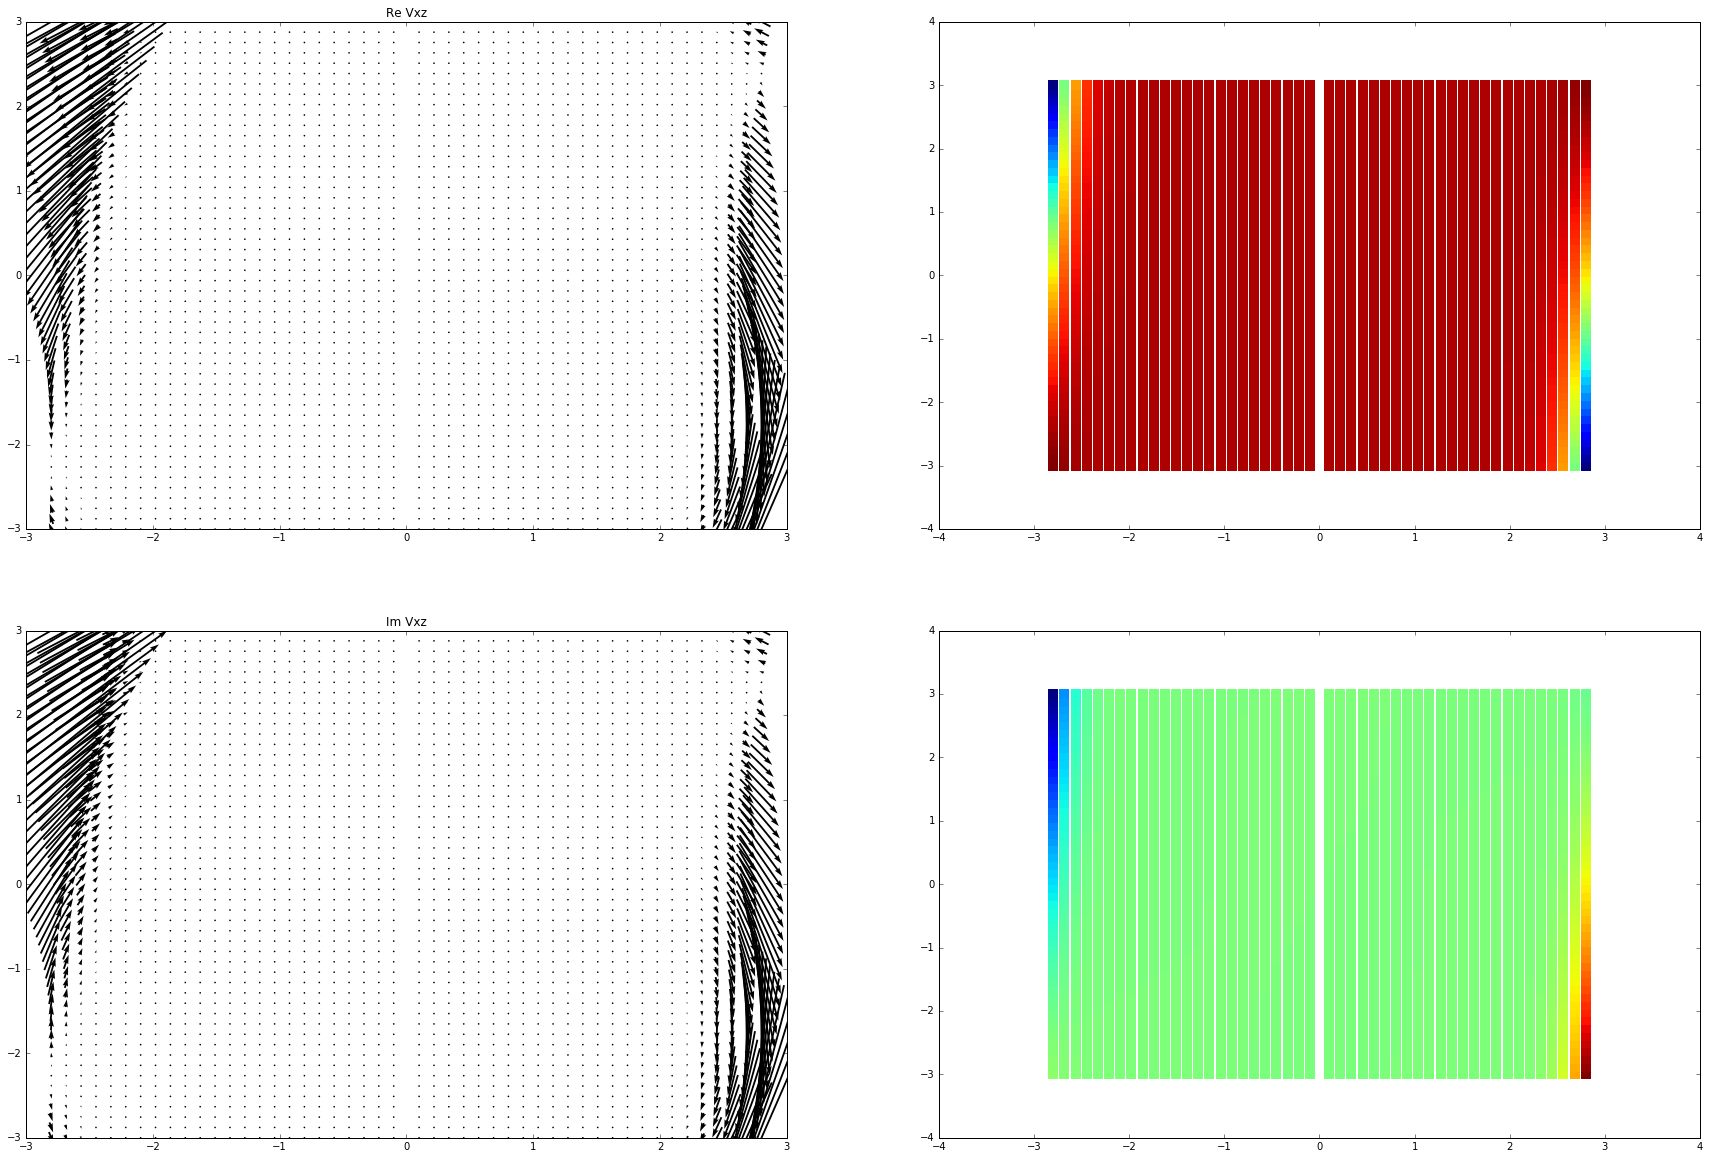

In [23]:
# Test posunů kulových vln
#%debug
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 20
z = np.linspace(-3,3)
y = [0]
x = np.concatenate((np.linspace(-2.8,-0.1,24),np.linspace(0.1,2.8,24)))

my, ny = get_mn_y(nmax)
nelem = len(my)
x,y,z = np.meshgrid(x,y,z)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

μ = 1
ν = 1
J = 1 # začnem zlehka

shift_r = 2.
shift_θ = 0.5
shift_φ = 0.0 # říkám zlehka

Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)

for y in range(nelem):
    Ã1_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    B̃1_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    ÃJ_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J)
    B̃J_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J)
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
    # TODO check r < d
    
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
# This will not work for J != 1
Mμν = np.sum(Ã1_y[ň,:,ň] * M_cart_ry[:,:,:] + B̃1_y[ň,:,ň] * N_cart_ry[:,:,:], axis=-2)

plotfield = Mμν[:,:]

#plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
#plotfield = M_cart_ry[:,7,:].imag
f, axarr = plt.subplots(2, 2, figsize=(30,20))
hor_axis = 0
perp_axis = 1
ver_axis = 2
print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
      "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
      "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
      "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
      "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
axarr[0,0].set_title("Re Vxz")
axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].real,marker='s')
#axarr[0,1].xlim[np.min(x),np.max(x)]
#axarr[0,1].ylim[np.min(z),np.max(z)]
axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
axarr[1,0].set_title("Im Vxz")
axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].imag,marker='s')


#plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))


In [20]:
B̃(-1,1,1,1,2.0,0.5,0.0,False,3)

0j

In [16]:
a_q(-2,1,1,1)

m,n,μ,ν,qm =  -2 1 1 1 0.5


ValueError: Something bad in the fortran subroutine gaunt_xu happened